In [29]:
"""
Adapted from code of Jacob Mattingley and EE364b Convex Optimization II codes.

This file solves a (random) instance of the problem:
    minimize    card(x)
    subject to  Ax <= b
using branch and bound, where x is the optimization variable and is in
{0,1}^30, A is in R^(100x30) and b is in R^(100x1).
"""
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [10]:
def round_to_zero(x, tol=1e-3):
    if isinstance(x, np.ndarray):
        return np.array([round_to_zero(y, tol) for y in x])
    elif abs(x) <= tol:
        return 0
    else:
        return x
    
def card(x):
    """Returns the cardinality (number of non-zero entries) of x."""
    return len([1 for y in round_to_zero(x) if y != 0])

def is_feasible(x, tol=1e-3):
    """Determines if x is in the feasible set Ax <= b (with tolerance)."""
    y = A @ x
    for i in range(len(y)):
        if y[i] - b[i] > tol:
            return False

    return True

def argmin(x, avoid=[]):
    """Returns the index of the minimum item in x with index not in the set
    avoid."""
    for i in range(len(x)):
        if i in avoid:
            x[i] = np.inf
    for i in range(len(x)):
        if x[i] == min(x):
            return i

In [11]:
class node:
    """node([n[, zeros[, ones[, parent]]]]) -> node object

    Create node of a branch-and-bound tree with size n.  Known-zero or
    known-one elements should be set using zeros and ones.
    """

    def __init__(self, n, zeros=[], ones=[], parent=None):
        if (set(zeros) & set(ones)):
            raise Exception('cannot have item fixed to zero and fixed to one')

        zeros.sort()
        ones.sort()

        self.zeros = zeros
        self.ones = ones
        self.parent = parent
        self.left = None
        self.right = None
        self.n = n
        self.alive = True
        self.lower = np.inf
        self.upper = np.inf
        self.prunedmass = 0

    def solve(self):
        """Find upper and lower bounds of the sub-problem belonging to
        this node."""
        x = cp.Variable(self.n)
        z = cp.Variable(self.n)

        constraints = [0 <= z, z <= 1,
                       cp.multiply(mins, z) <= x, x <= cp.multiply(maxes, z),
                       A @ x <= b]
        for i in self.ones:
            constraints.append(z[i] == 1)
        for i in self.zeros:
            constraints.append(z[i] == 0)

        # Use cvxopt to solve the problem.
        problem = cp.Problem(cp.Minimize(cp.sum(z)), constraints)
        problem.solve()

        if x.value is None:
            # We couldn't find a solution.
            self.raw = None
            self.rounded = None
            self.lower = np.inf
            self.upper = np.inf
            return np.inf

        # Use heuristic to choose which variable we should split on next. Don't
        # choose a variable we have already set.
        self.picknext = argmin(
            list(round_to_zero(abs(z.value - 0.5))), self.zeros + self.ones)

        self.lower = sum(z.value)

        if is_feasible(x.value):
            self.upper = card(x.value)
        else:
            self.upper = np.inf

        return self.upper

    def mass(self, fullonly=True):
        """Find the number of nodes which could live below this node."""
        p = self.n - len(self.zeros) - len(self.ones)
        return 2**p

    def addleft(self):
        """Add a node to the left-hand side of the tree and solve."""
        if self.left is None:
            self.left = node(self.n, self.zeros +
                             [self.picknext], self.ones, self)

        self.left.solve()
        return self.left

    def addright(self):
        """Add a node to the right-hand side of the tree and solve."""
        if self.right is None:
            self.right = node(self.n, self.zeros,
                              self.ones + [self.picknext], self)

        self.right.solve()
        return self.right

    def potential(self):
        """Returns the number of nodes that could still be added
        below this node."""
        return self.mass() - self.taken()

    def taken(self):
        """Returns the number of nodes that live below this node."""
        t = 0
        if self.left is not None:
            t += 1
            if self.left.alive:
                t += self.left.taken()
            else:
                t += self.left.mass()

        if self.right is not None:
            t += 1
            if self.right.alive:
                t += self.right.taken()
            else:
                t += self.right.mass()

        return t

    def __repr__(self):
        return '<node: mass=%d, zeros=%s, ones=%s>' % \
                (self.mass(), str(self.zeros), str(self.ones))

    def nodes(self, all=False):
        """Returns a list of all nodes that live at, or below, this point.

        If all is False, return nodes only if they are stil alive.
        """

        coll = []
        if self.alive or all:
            coll += [self]
        if self.left is not None and (self.left.alive or all):
            coll += self.left.nodes(all)
        if self.right is not None and (self.right.alive or all):
            coll += self.right.nodes(all)

        return coll

    def prune(self, upper):
        """Sets alive to False for any nodes in the tree with their lower less
        than upper.
        """

        # Note that we can use ceil(lower) instead of lower, because if we know
        # that cardinality is > 18.3, say, we know it must be 19 or more.
        if np.ceil(self.lower) > upper:
            p = self.parent
            while p is not None:
                p.prunedmass += self.mass() + 1
                p = p.parent
            self.alive = False
        else:
            if self.left is not None and self.left.alive:
                self.left.prune(upper)
            if self.right is not None and self.right.alive:
                self.right.prune(upper)

In [12]:
def argminl(nodes, Uglob):
    """Returns the node with lowest lower bound, from a list of nodes.
    """
    # Only considers nodes which can still be expanded.
    m = min([x.lower for x in nodes if x.potential() > 0])
    for x in nodes:
        if x.lower == m:
            return x

In [63]:
# Randomly generate data.
rng = np.random.default_rng(10)
m, n = 100, 30
A = rng.normal(size=(m, n))
x0 = rng.normal(size=n)
b = A.dot(x0) + 10 * rng.random(size=m)

In [64]:
# Find lower and upper bounds on each element of x. If we have that for a
# particular x_i, x_i > 0 or x_i < 0, we cannot hope to reduce the
# cardinality by setting that x_i to 0, so exclude index i from
# consideration by adding it to defones.
eps = 1e-04
defones = []
mins = np.zeros(n)
maxes = np.zeros(n)
x = cp.Variable(n)
for i in range(n):
    problem = cp.Problem(cp.Minimize(x[i]), [A @ x <= b])
    problem.solve()
    if problem.status != 'optimal':
        print("Problem status error: %s" % problem.status)
    if x.value[i] <= 0:
        x.value[i] *= 1.0001
    else:
        x.value[i] *= 1 / (1 + eps)
    mins[i] = x.value[i]

    problem = cp.Problem(cp.Minimize(-x[i]), [A @ x <= b])
    problem.solve() 
    if problem.status != 'optimal':
        print("Problem status error: %s" % problem.status)
    if x.value[i] <= 0:
        x.value[i] *= 1 / (1 + eps)
    else:
        x.value[i] *= (1 + eps)
    maxes[i] = x.value[i]
    if mins[i] > 0:
        defones.append(i)
    if maxes[i] < 0:
        defones.append(i)

In [ ]:
# Solve with Gurobi
x = cp.Variable(n)
z = cp.Variable(n, boolean=True)
problem = cp.Problem(cp.Minimize(cp.sum(z)), [
                   cp.multiply(mins, z) <= x, x <= cp.multiply(maxes, z),
                   A @ x <= b])
problem.solve(verbose=True)
x_grb = x.value
z_grb = z.value

In [66]:
# Various data structures for later plotting.
uppers = []
lowers = []
masses = []

# Create the top node in the tree.
top = node(n, ones=defones)
top.stillplotted = False

Uglob = top.solve()
Lglob = -np.inf
nodes = [top]
leaves = [top]
masses = []
leavenums = []
massesind = []
oldline = None
iter = 0
max_iter = 20000

In [67]:
# Expand the tree until the gap has disappeared.
while Uglob - Lglob > 1:
    iter += 1
    # Expand the leaf with lowest lower bound.
    l = argminl(leaves, Uglob)
    left = l.addleft()
    right = l.addright()
    leaves.remove(l)
    leaves += [left, right]

    Lglob = min([x.lower for x in leaves])
    Uglob = min(Uglob, left.upper, right.upper)

    lowers.append(Lglob)
    uppers.append(Uglob)

    for x in top.nodes():
        # Prune anything except the currently optimal solution. Doesn't
        # actually affect the progress of the algorithm.
        if x.lower > Uglob and x.upper != Uglob:
            x.alive = False

    if iter % 25 == 0:
        print("iter %3d.  lower bound: %.5f, upper bound: %.0f" %
              (iter, Lglob, Uglob))

    massesind.append(len(lowers))
    masses.append(top.potential() / top.mass())

    leavenums.append(len([1 for x in leaves if x.alive]))

    if iter >= max_iter:
        break

print("done.")

iter  25.  lower bound: 4.11353, upper bound: 12
iter  50.  lower bound: 4.60760, upper bound: 10
iter  75.  lower bound: 4.88700, upper bound: 10
iter 100.  lower bound: 5.08504, upper bound: 10
iter 125.  lower bound: 5.32081, upper bound: 10
iter 150.  lower bound: 5.46305, upper bound: 8
iter 175.  lower bound: 5.61959, upper bound: 8
iter 200.  lower bound: 5.72961, upper bound: 8
iter 225.  lower bound: 5.77268, upper bound: 8
iter 250.  lower bound: 5.82872, upper bound: 8
iter 275.  lower bound: 5.91322, upper bound: 8
iter 300.  lower bound: 5.97009, upper bound: 8
iter 325.  lower bound: 6.01283, upper bound: 8
iter 350.  lower bound: 6.09771, upper bound: 8
iter 375.  lower bound: 6.17197, upper bound: 8
iter 400.  lower bound: 6.22824, upper bound: 8
iter 425.  lower bound: 6.28350, upper bound: 8
iter 450.  lower bound: 6.34080, upper bound: 8
iter 475.  lower bound: 6.38545, upper bound: 8
iter 500.  lower bound: 6.43485, upper bound: 8
iter 525.  lower bound: 6.46115, up

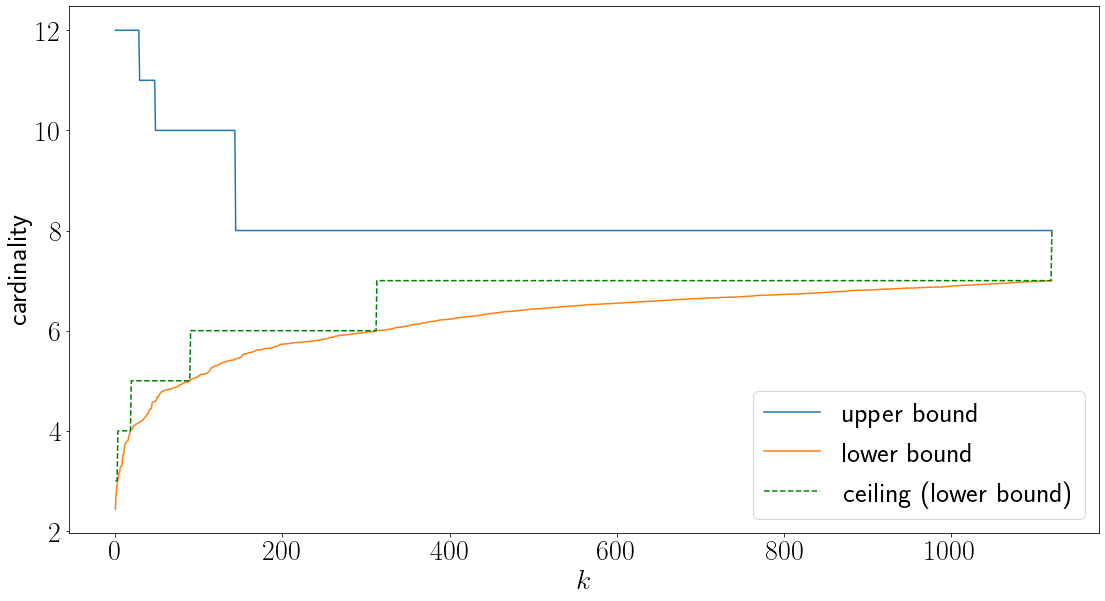

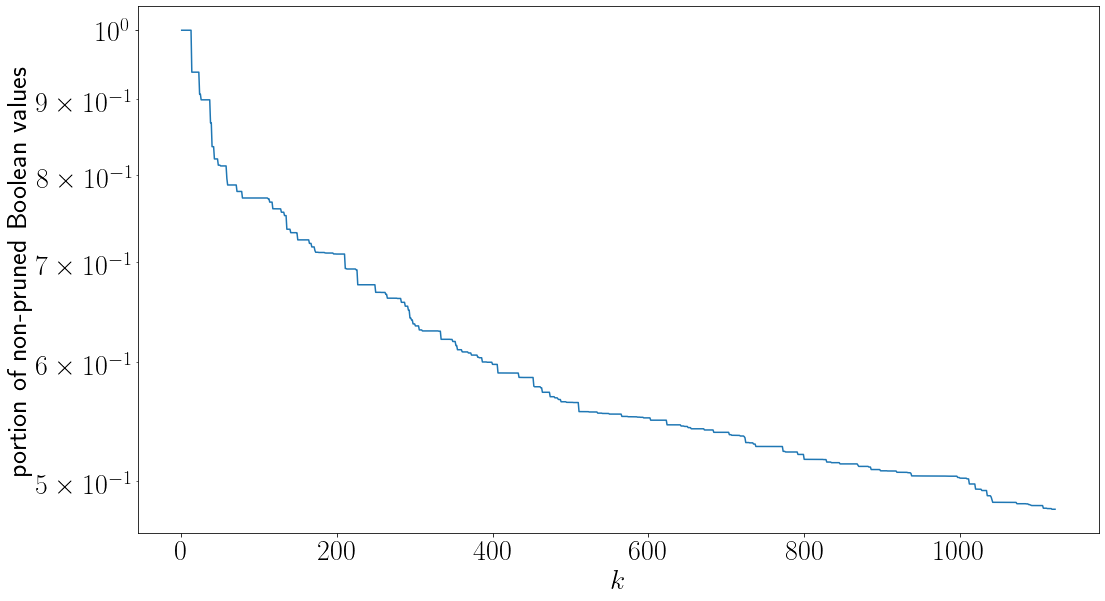

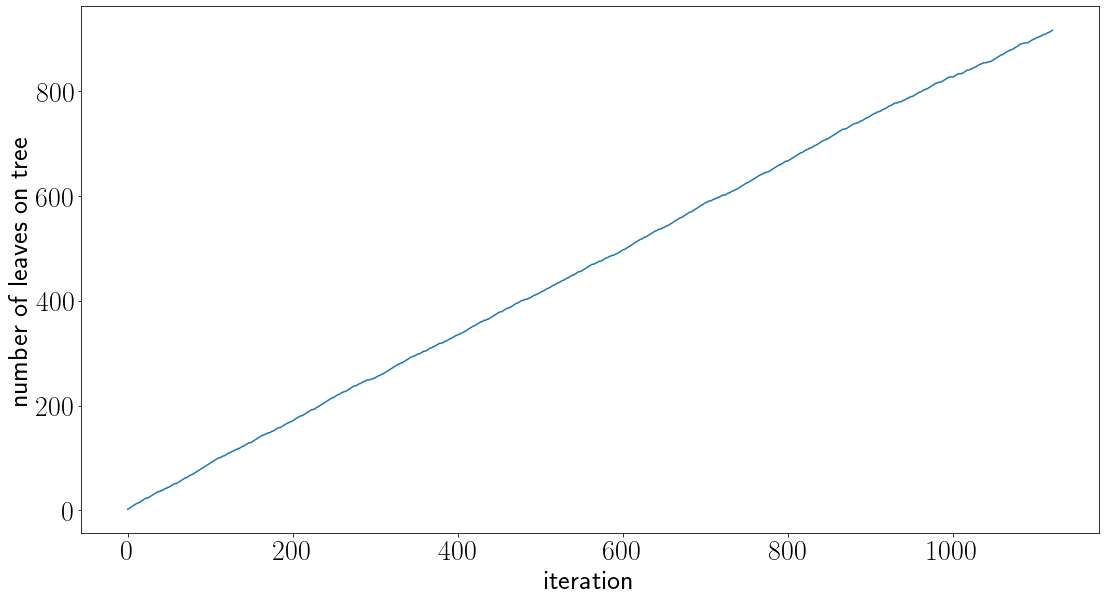

In [68]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(uppers)
ax.plot(lowers)
ax.plot(range(iter), np.ceil(lowers), 'g--')
ax.legend(('upper bound', 'lower bound',
          'ceiling (lower bound)'), loc='lower right')
ax.set_xlabel(r'$k$')
ax.set_ylabel('cardinality')
plt.tight_layout()
plt.savefig("bnb_bounds.pdf")

fig, ax = plt.subplots(figsize=(16, 9))
ax.semilogy(massesind, masses)
ax.set_xlabel(r'$k$')
ax.set_ylabel('portion of non-pruned Boolean values')
plt.tight_layout()
plt.savefig("bnb_pruned.pdf")

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(range(iter), leavenums)
ax.set_xlabel('iteration')
ax.set_ylabel('number of leaves on tree')
plt.tight_layout()
plt.savefig("bnb_tree_leaves.pdf")